In [1]:
import logging
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from searvey._ndbc_api import fetch_ndbc_stations_data,get_ndbc_stations
logging.basicConfig(
    level=20,
    style="{",
    format="{asctime:s}; {levelname:8s}; {threadName:23s}; {name:<25s} {lineno:5d}; {message:s}",
)

logging.getLogger("urllib3").setLevel(30)
logging.getLogger("parso").setLevel(30)

logger = logging.getLogger(__name__)

/home/abdu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Retrieve all NDBC stations

In [2]:
ndbc_stations = get_ndbc_stations()
ndbc_stations

/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/_html.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  components.extend(pd.read_html(str(tables), flavor='bs4'))
/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/stations.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(cls.APPLY_MAP)


,Station,Hull No./Config and Location,Wind Speed,Wind Direction,Sea Level Pressure,Wave Height,Dominant Period,Air Temp,Water Temp,Dew Point,Remark,lat,ns,lon,ew,geometry
0,41001,3D90 (SC) East Hatteras,100,100,100,100,100,100,100,100,NaN,34.70,N,-72.23,W,POINT (-72.23000 34.70000)
1,41002,3DV33 (SC) South Hatteras,100,100,100,100,100,100,99,100,NaN,31.75,N,-74.93,W,POINT (-74.93000 31.75000)
2,41004,3DV02 (SC) Edisto,100,100,100,100,100,100,99,100,NaN,32.50,N,-79.08,W,POINT (-79.08000 32.50000)
3,41008,3D36 (SC) Grays Reef,100,100,100,99,99,100,98,100,All data is intermittent after 8/18/23.,31.40,N,-80.85,W,POINT (-80.85000 31.40000)
4,41009,3D65 (SC) Canaveral,100,100,100,99,99,100,99,100,Water temperature ceased 3/25/23. Air temperat...,28.50,N,-80.18,W,POINT (-80.18000 28.50000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,SRST2,"(MA) Sabine Pass, Tx",Sensor/system failure.,Sensor/system failure.,1,No sensor installed.,No sensor installed.,1,No sensor installed.,Sensor/system failure.,Dewpoint intermittent due to frequent supersat...,29.68,N,-94.03,W,POINT (-94.03000 29.68000)
36,STDM4,"(SU) Stannard Rock, Mi",Sensor/system failure.,Sensor/system failure.,Sensor/system failure.,No sensor installed.,No sensor installed.,Sensor/system failure.,No sensor installed.,Sensor/system failure.,Wind direction and speed failed 4/4/24. Barome...,47.18,N,-87.22,W,POINT (-87.22000 47.18000)
37,TPLM2,"(MA) Thomas Point, Md",100,100,100,No sensor installed.,No sensor installed.,100,Sensor/system failure.,Sensor/system failure.,Water temperature sensor removed 07/14/22. Dew...,38.88,N,-76.43,W,POINT (-76.43000 38.88000)
38,VENF1,"(AR) Venice, Fl",100,100,100,No sensor installed.,No sensor installed.,100,100,100,NaN,27.07,N,-82.45,W,POINT (-82.45000 27.07000)


## Visualize the location of the stations on a map

/tmp/ipykernel_15509/312900082.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


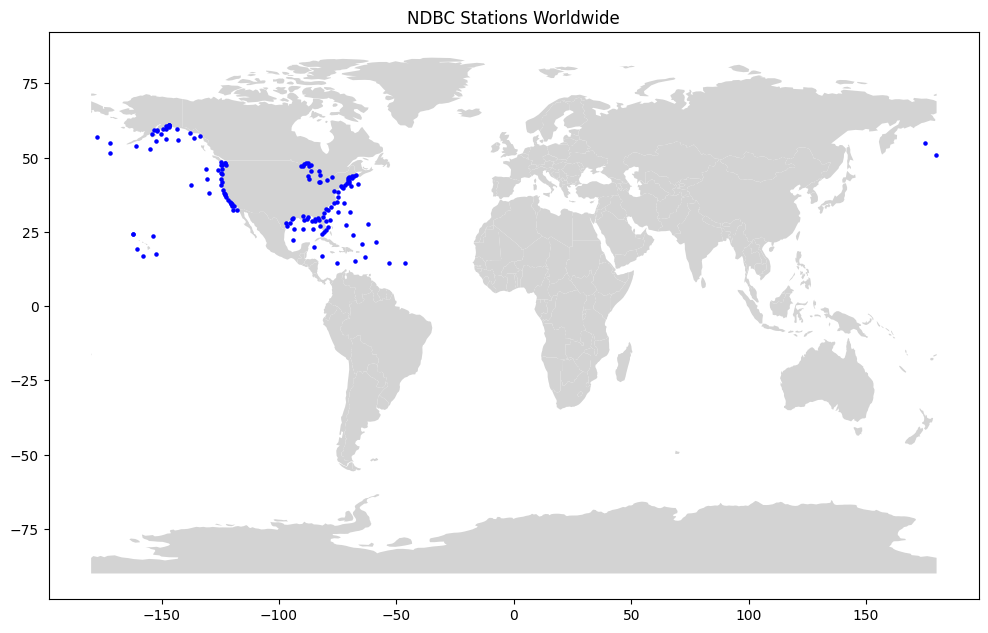

In [3]:
# Create the plot
def plot_map(data, title):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 12 / 1.61803398875)

    # Plot the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(color='lightgrey', ax=ax, zorder=-1)

    # Plot the NDBC stations
    data.plot(ax=ax, color='blue', markersize=5) 

    ax.set_title(title)
    plt.show()

plot_map(ndbc_stations, 'NDBC Stations Worldwide')

## Get the stations from a specific region and vizulaise it in a map

/tmp/ipykernel_15509/312900082.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


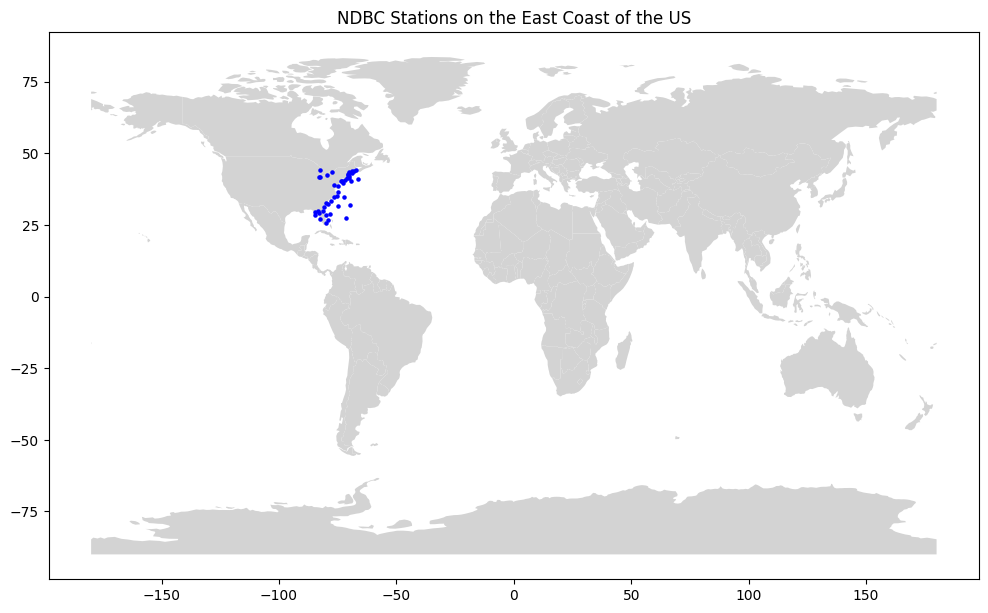

In [4]:
from shapely.geometry import box
# Define a rectangular region
region = box(-85, 25, -65, 45)  # Longitude range, Latitude range

# Get stations within the region
east_coast_stations = get_ndbc_stations(region=region)
plot_map(east_coast_stations, 'NDBC Stations on the East Coast of the US')

Not all stations provide the same set of measurements, the following measurements are listed and which type of stations support them:

```markdown

| Package Name          | C-MAN  | Moored |
|-----------------------|--------|--------|
| adcp                  | [ ]    | [ ]    |
| cwind                 | [X]    | [ ]    |
| ocean                 | [ ]    | [ ]    |
| spec                  | [ ]    | [ ]    |
| stdmet                | [X]    | [ ]    |
| supl                  | [ ]    | [X]    |
| swden                 | [ ]    | [X]    |
| swdir                 | [ ]    | [X]    |
| swdir2                | [ ]    | [X]    |
| swr1                  | [ ]    | [X]    |
| swr2                  | [ ]    | [X]    |
```


(note: stations that are with only numbers are usually Moored Buoyse e.g. 44008 and stations with a mixture of numbers and letters are C-MAN owned e.g. BUZM3)
C-MAN -> Numbers only
Moored Buoyse -> numbers and letters

The table was tested at the start of june 2024 and may differ as support for different stations status may change.

Note: If an error is logged,it may be because one of the stations does not have the data of the mode


## Retrieve Data for Selected Stations

In [5]:
# Define start and end dates for data retrieval
start_date = "2023-01-01"
end_date = "2023-01-10"

# Get data for selected stations (mode = 'stdmet' for standard meteorological data)
station_ids = east_coast_stations["Station"].tolist()[1:3]
data_df = fetch_ndbc_stations_data(
    station_ids=["SRST2","VENF1"],
    mode="stdmet",
    start_date=start_date,
    end_date=end_date,
)

#output is a dictionary of {station id : data}
data_to_plot = data_df["SRST2"]
data_to_plot

  0%|          | 0/2 [00:00<?, ?it/s]/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/_base.py:57: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/_base.py:57: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
 50%|█████     | 1/2 [00:00<00:00,  1.62it/s]/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/_base.py:57: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/home/abdu/.local/lib/python3.10/site-packages/ndbc_api/api/parsers/_base.py:57: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is de

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
timestamp,,,,,,,,,,,,,
2023-01-01 00:00:00,159.0,3.9,5.2,NaN,NaN,NaN,NaN,1014.5,12.3,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,153.0,2.6,3.2,NaN,NaN,NaN,NaN,1014.5,12.7,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,148.0,3.4,4.3,NaN,NaN,NaN,NaN,1014.9,12.5,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,148.0,4.8,6.8,NaN,NaN,NaN,NaN,1014.9,12.8,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,128.0,2.4,3.4,NaN,NaN,NaN,NaN,1015.2,13.3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 20:00:00,106.0,7.0,8.5,NaN,NaN,NaN,NaN,1022.1,15.4,NaN,NaN,NaN,NaN
2023-01-09 21:00:00,108.0,5.4,6.8,NaN,NaN,NaN,NaN,1022.0,15.3,NaN,NaN,NaN,NaN
2023-01-09 22:00:00,93.0,6.2,7.9,NaN,NaN,NaN,NaN,1021.6,15.5,NaN,NaN,NaN,NaN


## Plot the data of the dataframes

<Axes: xlabel='timestamp'>

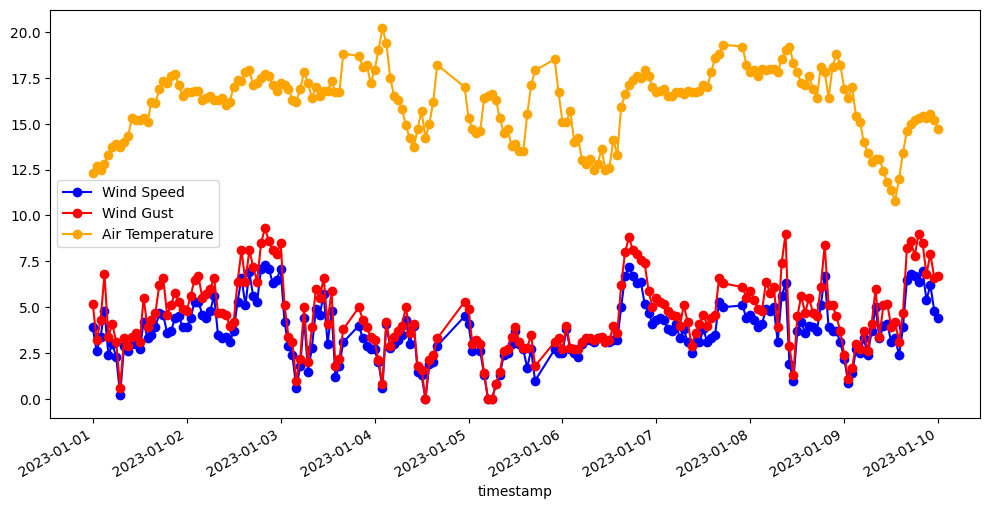

In [7]:
# Plot the data of data_to_plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

data_to_plot.plot(y="WSPD", ax=ax, color="blue", linestyle="-", marker="o", label="Wind Speed")
data_to_plot.plot(y="GST", ax=ax, color="red", linestyle="-", marker="o", label="Wind Gust")
data_to_plot.plot(y="ATMP", ax=ax, color="orange", linestyle="-", marker="o", label="Air Temperature")

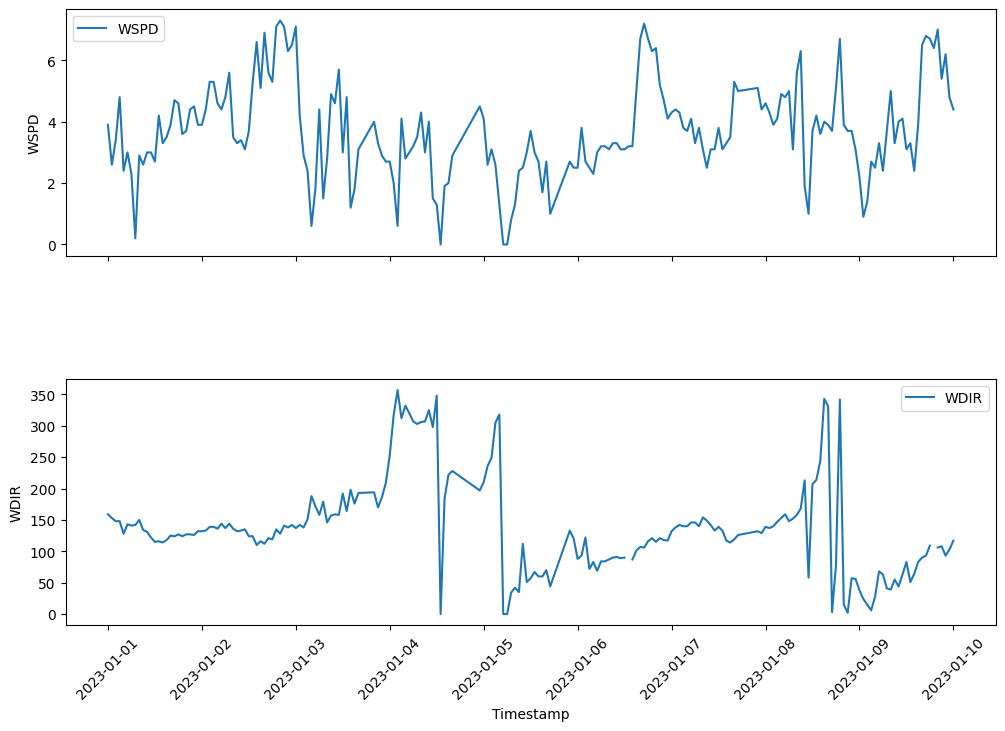

In [8]:
# Create a figure and three subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Plot WSPD
ax1.plot(data_to_plot.index, data_to_plot['WSPD'], label='WSPD')
ax1.set_ylabel('WSPD')
ax1.legend()



# Plot WTIME
ax2.plot(data_to_plot.index, data_to_plot['WDIR'], label='WDIR')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('WDIR')
ax2.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()